In [68]:
import pandas as pd
import os
from glob import glob
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

In [2]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: NVIDIA A100-PCIE-40GB


In [3]:
# read corpora
ambitious = pd.read_csv('../corpora/ambitious_goals.csv').drop("Unnamed: 0", axis=1)
confidence = pd.read_csv('../corpora/confidence_in_goals.csv').drop("Unnamed: 0", axis=1)
contrast = pd.read_csv('../corpora/contrast.csv').drop("Unnamed: 0", axis=1)
lists = pd.read_csv('../corpora/lists_repetitions.csv').drop("Unnamed: 0", axis=1)
similie = pd.read_csv('../corpora/metaphor_similie.csv').drop("Unnamed: 0", axis=1)
rhetoricalq = pd.read_csv('../corpora/rhetorical_question.csv').drop("Unnamed: 0", axis=1)
sentiment = pd.read_csv('../corpora/sentiment_of_the_collective.csv').drop("Unnamed: 0", axis=1)
story = pd.read_csv('../corpora/story_anecdote.csv').drop("Unnamed: 0", axis=1)
vua_metaphor = pd.read_csv('../corpora/vua_metaphor.csv')
vua_metaphor = vua_metaphor[['sentence', 'label']].rename(columns={'label':'Metaphor', 'sentence':'Results'})
moral_conv = pd.read_csv('../corpora/moral_convictions.csv').rename(columns={'sentence':'Results'})

In [4]:
dfs = [ambitious, confidence, contrast, lists, similie, rhetoricalq, sentiment, story, vua_metaphor, moral_conv]
data = pd.concat(dfs, ignore_index=True).fillna(0)
data['Results'] = data['Results'].apply(lambda x: x.replace('"',''))
data = data.rename(columns={'Results':'sentence'})
data

,sentence,ambitious_goals,confidence_in_goals,contrast,repetition,similie,rhetorical_question,sentiment_of_the_collective,story_anecdote,Metaphor,Moral_conviction
0,"Within the next three years, we are determined...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"By 2030, our company's revenue will surpass $1...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"In the next five years, we will establish part...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"By 2025, we will successfully reduce our energ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Within the next decade, we intend to open 100 ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
84763,We cannot allow our personal biases to lead us...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
84764,It is important to hold ourselves and our inst...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
84765,The long-term consequences of our actions can ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
84766,We must ensure that our policies do not transg...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [71]:
from sklearn.model_selection import train_test_split
y = data.drop(columns=['sentence']).values #get the labels
train, test = train_test_split(data, test_size=0.2, random_state=1337, shuffle=True)


In [72]:
sentences = train.sentence.values
labels =  train.drop(columns=['sentence']).values

In [73]:
np.unique(labels)

array([ 0.,  1.,  2., 11.])

In [74]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [75]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Shouldn't we strive to be the best versions of ourselves, no matter the circumstances?
Token IDs: [101, 5807, 1005, 1056, 2057, 29453, 2000, 2022, 1996, 2190, 4617, 1997, 9731, 1010, 2053, 3043, 1996, 6214, 1029, 102]


In [76]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  188


In [77]:
# get the distribution of sentence lengths
sentences_len = [len(sen) for sen in sentences]
sentences_len[:5]

[86, 150, 48, 105, 173]

In [78]:
# We'll use the `pad_sequences` utility function to do this.
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Set the maximum sequence length.
# 149 is the mean of sequence lengths
MAX_LEN = max([len(sen) for sen in input_ids])
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

labels = torch.tensor(labels,dtype=torch.long)
print('\Done.')


Padding/truncating all sentences to 188 values...

Padding token: "[PAD]", ID: 0
\Done.


In [79]:
# Create attention masks
attention_masks = []
# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [80]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)


In [81]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/tmp/ipykernel_3201103/268205451.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
/tmp/ipykernel_3201103/268205451.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_labels = torch.tensor(validation_labels)


In [82]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
batch_size = 128#*labels.shape[1] #32 # 32*11
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [83]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = labels.shape[1], # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    problem_type="multi_label_classification",
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
#problem_type="multi_label_classification"
)
# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [84]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [85]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup
# Number of training epochs (authors recommend between 2 and 4)
epochs = 100
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 5, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/home/datasciencefhswf/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [86]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [87]:
print(torch.cuda.memory_summary(device=None, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1254 MB |   21790 MB |    3761 TB |    3761 TB |
|---------------------------------------------------------------------------|
| Active memory         |    1254 MB |   21790 MB |    3761 TB |    3761 TB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |   22734 MB |   22734 MB |   22734 MB |       0 B  |
|---------------------------------------------------------------

In [88]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
torch.cuda.empty_cache()
seed_val = 421337
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels.to(torch.float))
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:14.
  Batch   120  of    477.    Elapsed: 0:01:51.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    Elapsed: 0:03:06.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:21.
  Batch   320  of    477.    Elapsed: 0:04:58.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:13.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.10
  Training epoch took: 0:07:25

Running Validation...


/tmp/ipykernel_3201103/18900293.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 2 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:21.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:13.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.05
  Training epoch took: 0:07:25

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 3 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:30.
  Batch   200  of    477.    Ela


  Average training loss: 0.02
  Training epoch took: 0:07:25

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 14 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:21.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.02
  Training epoch took: 0:07:25

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 15 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0

  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.01
  Training epoch took: 0:07:25

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 26 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:22.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.01
  Training epoch took: 0:07:25

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 27 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0

  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.01
  Training epoch took: 0:07:26

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 38 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:22.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.01
  Training epoch took: 0:07:26

Running Validation...
  Accuracy: 0.00
  Validation took:

  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:22.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.01
  Training epoch took: 0:07:25

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 50 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:22.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 

  Batch   160  of    477.    Elapsed: 0:02:30.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:22.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.01
  Training epoch took: 0:07:26

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 62 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:22.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477. 

  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:22.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.01
  Training epoch took: 0:07:25

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 74 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:30.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:22.
  Batch   320  of    477. 

  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:22.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.01
  Training epoch took: 0:07:25

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 86 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477. 

  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 97 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:30.
  Batch   200  of    477.    Elapsed: 0:03:07.
  Batch   240  of    477.    Elapsed: 0:03:44.
  Batch   280  of    477.    Elapsed: 0:04:22.
  Batch   320  of    477.    Elapsed: 0:04:59.
  Batch   360  of    477.    Elapsed: 0:05:36.
  Batch   400  of    477.    Elapsed: 0:06:14.
  Batch   440  of    477.    Elapsed: 0:06:51.

  Average training loss: 0.01
  Training epoch took: 0:07:26

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:17

======== Epoch 98 / 100 ========
Training...
  Batch    40  of    477.    Elapsed: 0:00:37.
  Batch    80  of    477.    Elapsed: 0:01:15.
  Batch   120  of    477.    Elapsed: 0:01:52.
  Batch   160  of    477.    Elapsed: 0:02:29.
  Batch   200  of    477.    E

In [89]:
torch.save(model.state_dict(),'CharismaBERT100_shuffled_state_dict.pt')
torch.save(model, 'CharismaBERT100_shuffled.pt')

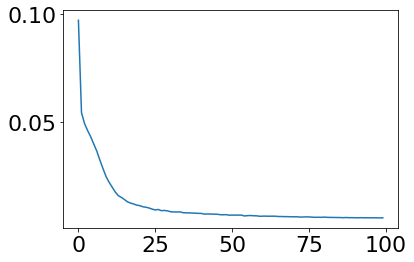

In [90]:
import matplotlib.pyplot as plt
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = plt.plot(f.index, f.Loss)
plt.show()

In [91]:

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test.shape[0]))
# Create sentence and label lists
sentences = test.sentence.values
labels = test.drop(columns=['sentence']).values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
labels = torch.tensor(labels,dtype=torch.long)
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
# Set the batch size.  
batch_size = 32  
# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 16,954



/tmp/ipykernel_3201103/2840356787.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_labels = torch.tensor(labels)


In [92]:
import tensorflow as tf
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels, prediction_probs = [], [],[] #Atefeh
# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
    logits = outputs[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    prediction_probs.append (tf.nn.softmax(logits))

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
print('DONE.')

Predicting labels for 16,954 test sentences...
DONE.


In [93]:
prediction_probs[:1]

[<tf.Tensor: shape=(32, 10), dtype=float32, numpy=
 array([[4.59503280e-09, 6.76232448e-09, 4.74574469e-09, 3.53613405e-09,
         1.05094724e-08, 9.99538319e-09, 2.94234725e-09, 1.00000000e+00,
         2.96498470e-08, 2.32876052e-09],
        [7.71659033e-05, 2.66076205e-03, 5.95624140e-03, 9.16725457e-01,
         2.93135503e-03, 2.35123690e-02, 1.06610693e-02, 2.05515604e-03,
         3.51997390e-02, 2.20742397e-04],
        [1.78015307e-02, 4.37224656e-02, 6.35977909e-02, 5.22496030e-02,
         8.33447427e-02, 6.35719672e-02, 9.03445035e-02, 2.11566407e-02,
         5.53674221e-01, 1.05365105e-02],
        [1.00608419e-08, 1.09009271e-07, 9.99998808e-01, 7.58346985e-08,
         7.25636298e-08, 4.54746001e-08, 5.09005815e-08, 1.86972979e-08,
         7.39873769e-07, 1.54166524e-09],
        [7.65628116e-11, 3.14294230e-10, 2.67297268e-10, 1.32524811e-10,
         3.00420355e-10, 2.60625660e-10, 7.41306877e-11, 8.46865564e-11,
         1.14050247e-09, 1.00000000e+00],
        [

In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report
accs_set = []
print(predictions[0].shape)
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    true_labels_i = np.argmax(true_labels[i], axis=1).flatten()
    #print(pred_labels_i)
  # Calculate and store the coef for this batch.  
    acc = accuracy_score(true_labels_i, pred_labels_i)                
    accs_set.append(acc)

(32, 10)
Calculating Matthews Corr. Coef. for each batch...


In [95]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = np.argmax(flat_true_labels, axis=1).flatten()
# Calculate the MCC
acc = accuracy_score(flat_true_labels, flat_predictions)
print('ACC: %.3f' % acc)

ACC: 0.260


In [96]:
confusion_matrix=confusion_matrix(flat_true_labels, flat_predictions)
confusion_matrix

array([[ 203,  527,  644, 1338,  412, 1100,  549,  321, 6535,   21],
       [   0,  123,    1,    3,    5,    0,    3,    0,   96,    0],
       [   0,    0,  311,   10,    1,    0,    1,    0,  173,    5],
       [   0,    3,    9,  394,    4,    2,   10,    3,  263,    1],
       [   0,    0,    1,    7,  110,    0,    4,    2,   90,    0],
       [   0,    2,    0,    0,    0,  307,    1,    0,  137,    0],
       [   0,    2,    2,    3,    1,    0,  289,    0,  123,    0],
       [   0,    0,    1,    0,    0,    0,    4,  139,   89,    0],
       [   0,    0,    6,    2,    2,    4,    4,    1, 1233,    3],
       [   0,    1,    2,    3,    0,    0,    6,    0,    2, 1300]])

In [97]:
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       1.00      0.02      0.03     11650
           1       0.19      0.53      0.28       231
           2       0.32      0.62      0.42       501
           3       0.22      0.57      0.32       689
           4       0.21      0.51      0.29       214
           5       0.22      0.69      0.33       447
           6       0.33      0.69      0.45       420
           7       0.30      0.60      0.40       233
           8       0.14      0.98      0.25      1255
           9       0.98      0.99      0.98      1314

    accuracy                           0.26     16954
   macro avg       0.39      0.62      0.38     16954
weighted avg       0.82      0.26      0.18     16954



['ambitious_goals' 'confidence_in_goals' 'contrast' 'repetition' 'similie'
 'rhetorical_question' 'sentiment_of_the_collective' 'story_anecdote'
 'Metaphor' 'Moral_conviction']


[Text(0, 0.5, 'ambitious_goals'),
 Text(0, 1.5, 'confidence_in_goals'),
 Text(0, 2.5, 'contrast'),
 Text(0, 3.5, 'repetition'),
 Text(0, 4.5, 'similie'),
 Text(0, 5.5, 'rhetorical_question'),
 Text(0, 6.5, 'sentiment_of_the_collective'),
 Text(0, 7.5, 'story_anecdote'),
 Text(0, 8.5, 'Metaphor'),
 Text(0, 9.5, 'Moral_conviction')]

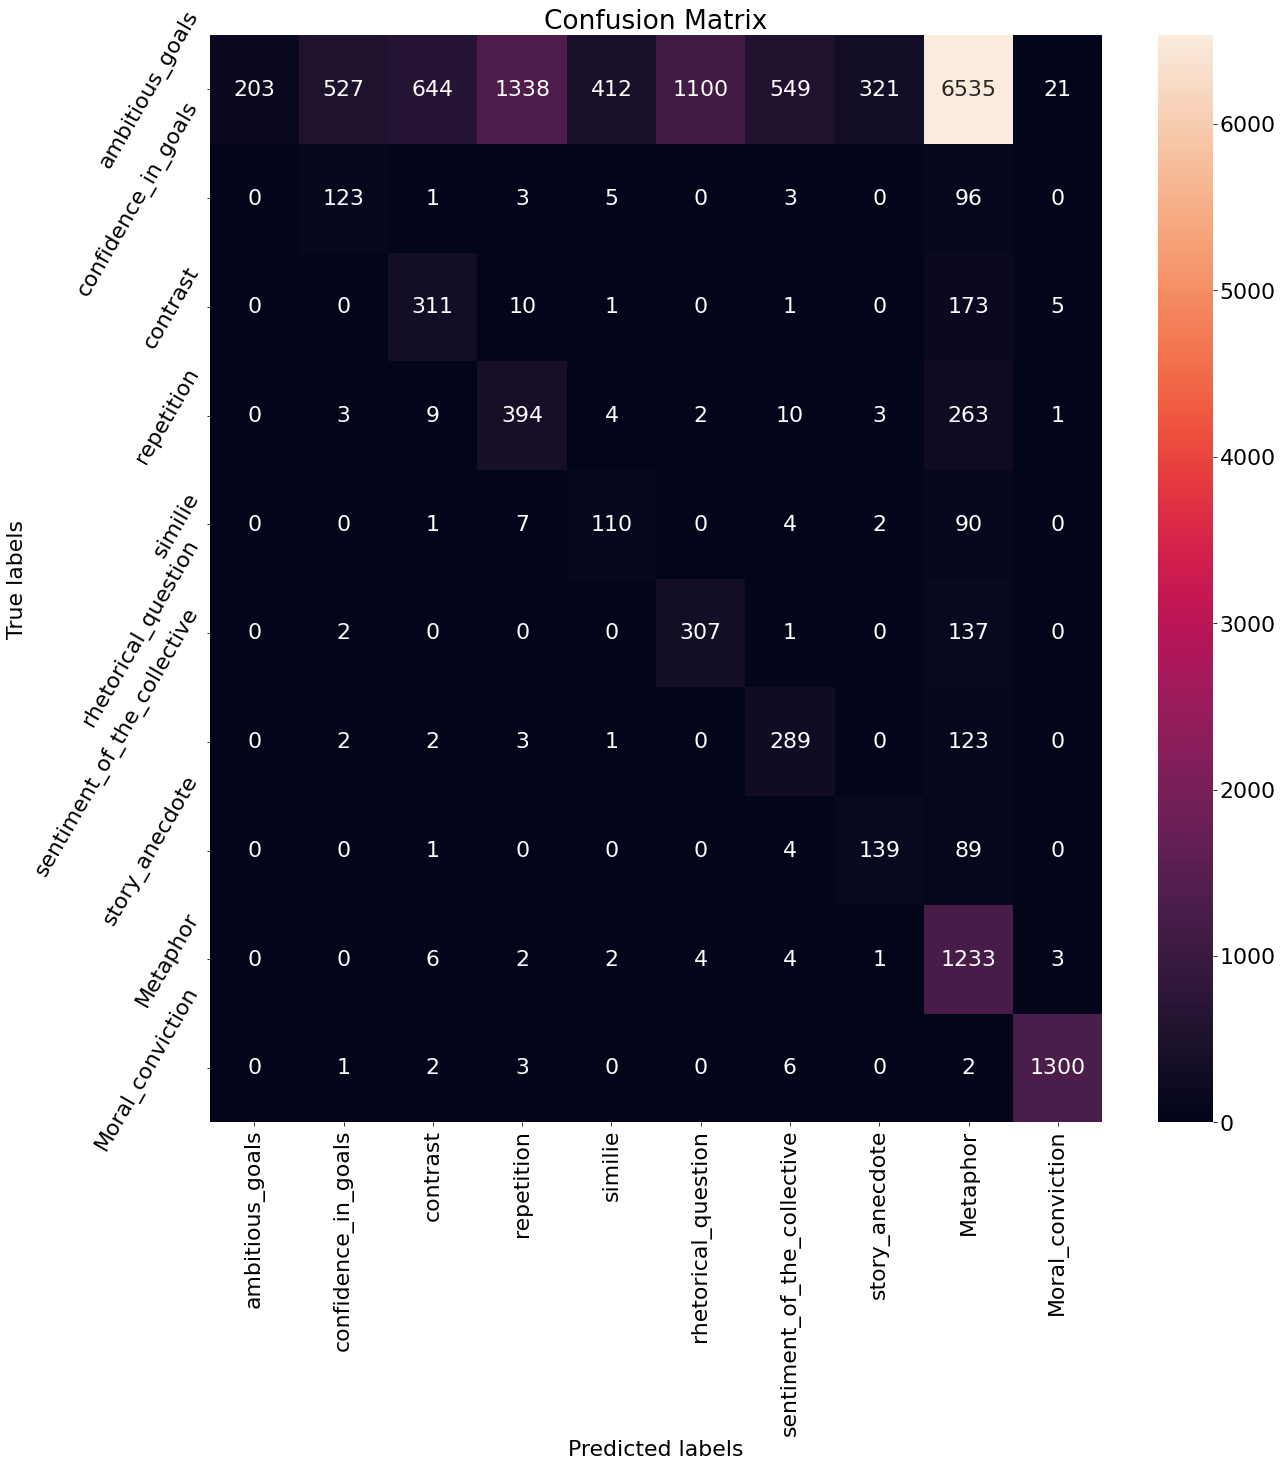

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
labels = data.keys().values
print(labels[1:])
fig, ax = plt.subplots( figsize=(20, 20))
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels[1:],rotation=90)
ax.yaxis.set_ticklabels(labels[1:],rotation=60)